**Data Input**

In [ ]:
import csv
import numpy as np
np.set_printoptions(suppress=True)

with open('student-mat.csv', newline='') as csv_file:
    data = list(csv.reader(csv_file, delimiter=';'))
    # remove the first line in the file
    data.pop(0)
    data = np.asarray(data)
    categorical = data[:, 0:29]

**Transform categorical features into one-hot representation**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical = OneHotEncoder(sparse=False).fit_transform(categorical)

**Shuffle the data**

In [ ]:
data = np.concatenate((categorical, data[:, 29:33]), axis=1).astype(float)
np.random.shuffle(data)

**Transform label format - Binary classification**

In [ ]:
x = np.copy(data[:, 0:-1])
y = np.copy(data[:, -1])
np.putmask(y, y<10, 0)
np.putmask(y, y!=0, 1)

**Decision Tree**

The tree is built by sciki-learn function.<br>
The metrics are also calculated by sciki-learn functions.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

model = DecisionTreeClassifier()
pca_model = DecisionTreeClassifier()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

kf = KFold(n_splits=3)

test = []
pred = []
pca_pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

  pca = PCA(n_components=4).fit(x_train)
  pca_model.fit(pca.transform(x_train), y_train)
  pca_y_pred = pca_model.predict(pca.transform(x_test))
  pca_pred.extend(pca_y_pred)

print('Decision Tree')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))
print('')
print('Decision Tree - PCA')
print('Confusion matrix')
print(confusion_matrix(test, pca_pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pca_pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pca_pred)))
print('Precision: ' + str(precision_score(test, pca_pred)))


Decision Tree
Confusion matrix
[[33.66666667  9.66666667]
 [ 7.         81.33333333]]
Accuracy: 0.8734177215189873
Sensitivity(Recall): 0.9207547169811321
Precision: 0.8937728937728938

Decision Tree - PCA
Confusion matrix
[[34.33333333  9.        ]
 [ 8.         80.33333333]]
Accuracy: 0.8708860759493671
Sensitivity(Recall): 0.909433962264151
Precision: 0.8992537313432836


**Question - Show the prediction and reasoning of one arbitrary sample in the testing set**

decision node 0 : (x_test[105] = 19.0) > 9.5)
decision node 30 : (x_test[105] = 19.0) > 10.5)

Prediction: 1.0
Groung truth: 1.0


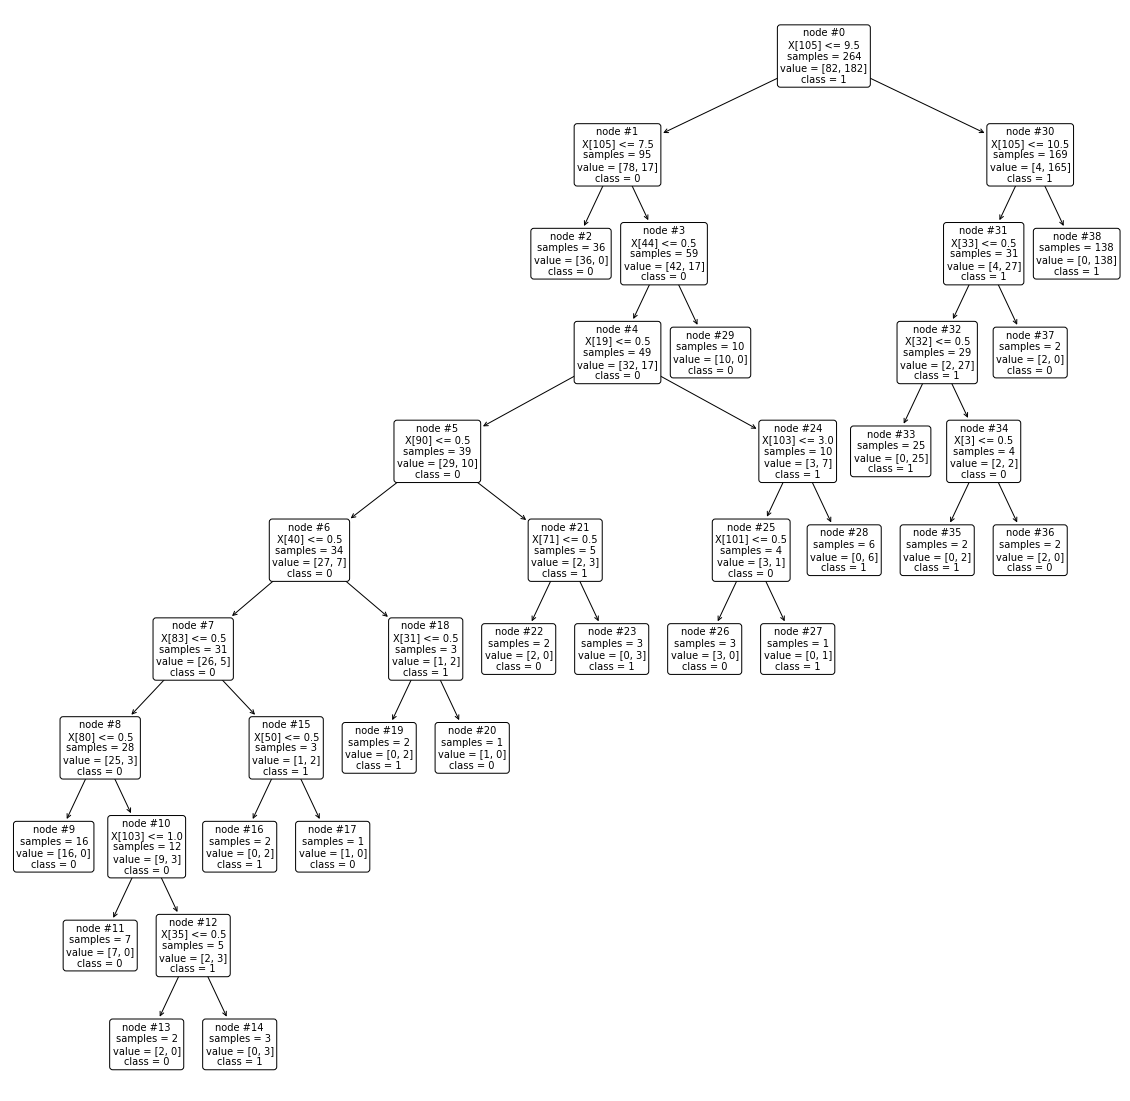

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20, 20))
tree.plot_tree(model, class_names=['0', '1'], impurity=False, node_ids=True, rounded=True)

feature = model.tree_.feature
threshold = model.tree_.threshold
node_indicator = model.decision_path(x_test[0:1])
leaf_id = model.apply(x_test[0:1])

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

# print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if x_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (x_test[{feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=x_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

print("")
print("Prediction: " + str(model.predict(x_test[0:1])[0]))
print("Groung truth: " + str(y_test[0]))

**Random Forest**

KFold cross-validation: a method used to split data into validation set and training set.<br>
Random Forest: a kind of model structure which generates prediction by combining the predictions generated by different decision trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pca_model = RandomForestClassifier()

In [ ]:
kf = KFold(n_splits=3)

test = []
pca_pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)

  pca = PCA(n_components=4).fit(x_train)
  pca_model.fit(pca.transform(x_train), y_train)
  pca_y_pred = pca_model.predict(pca.transform(x_test))
  pca_pred.extend(pca_y_pred)

print('Random Forest - PCA')
print('Confusion matrix')
print(confusion_matrix(test, pca_pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pca_pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pca_pred)))
print('Precision: ' + str(precision_score(test, pca_pred)))

Random Forest - PCA
Confusion matrix
[[37.33333333  6.        ]
 [ 7.33333333 81.        ]]
Accuracy: 0.8987341772151899
Sensitivity(Recall): 0.9169811320754717
Precision: 0.9310344827586207


In [ ]:
model = RandomForestClassifier(n_estimators=50)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('Random Forest - 50')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))

Random Forest - 50
Confusion matrix
[[35.66666667  7.66666667]
 [ 6.66666667 81.66666667]]
Accuracy: 0.8911392405063291
Sensitivity(Recall): 0.9245283018867925
Precision: 0.914179104477612


In [ ]:
model = RandomForestClassifier(n_estimators=100)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('Random Forest - 100')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))

Random Forest - 100
Confusion matrix
[[36.33333333  7.        ]
 [ 7.         81.33333333]]
Accuracy: 0.8936708860759494
Sensitivity(Recall): 0.9207547169811321
Precision: 0.9207547169811321


In [ ]:
model = RandomForestClassifier(n_estimators=200)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('Random Forest - 200')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))

Random Forest - 200
Confusion matrix
[[36.          7.33333333]
 [ 5.33333333 83.        ]]
Accuracy: 0.9037974683544304
Sensitivity(Recall): 0.939622641509434
Precision: 0.9188191881918819


**Question - Describe the difference between boosting and bagging**

Boosting: combine several weak classifier into a strong classifier.

Bagging: randomly draw a certain amount of samples, use these drawn data to construct a model, then put the drawn data back so it can be drawn again.

**K-Nearest Neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pca_model = KNeighborsClassifier()

In [ ]:
kf = KFold(n_splits=3)

test = []
pca_pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)

  pca = PCA(n_components=2).fit(x_train)
  pca_model.fit(pca.transform(x_train), y_train)
  pca_y_pred = pca_model.predict(pca.transform(x_test))
  pca_pred.extend(pca_y_pred)

print('K-Nearest Neighbor - PCA')
print('Confusion matrix')
print(confusion_matrix(test, pca_pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pca_pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pca_pred)))
print('Precision: ' + str(precision_score(test, pca_pred)))

K-Nearest Neighbor - PCA
Confusion matrix
[[35.66666667  7.66666667]
 [11.66666667 76.66666667]]
Accuracy: 0.8531645569620253
Sensitivity(Recall): 0.8679245283018868
Precision: 0.9090909090909091


**Bonus: pick 2 features, draw and describe the KNN decision boundaries**

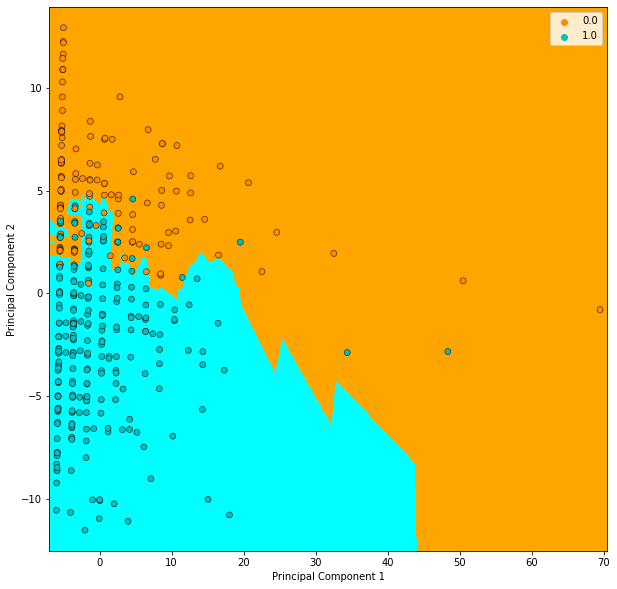

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan"])
cmap_bold = ["darkorange", "c"]

pca_x = pca.transform(x)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = pca_x[:, 0].min() - 1, pca_x[:, 0].max() + 1
y_min, y_max = pca_x[:, 1].min() - 1, pca_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
z = pca_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
z = z.reshape(xx.shape)
plt.figure(figsize = (10,10))
plt.contourf(xx, yy, z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=pca_x[:, 0],
    y=pca_x[:, 1],
    hue=y,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
model = KNeighborsClassifier(n_neighbors=2)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('K-Nearest Neighbor - 2')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))

K-Nearest Neighbor - 2
Confusion matrix
[[39.33333333  4.        ]
 [18.33333333 70.        ]]
Accuracy: 0.830379746835443
Sensitivity(Recall): 0.7924528301886793
Precision: 0.9459459459459459


**Question - Show the prediction and reasoning of one arbitrary sample in the testing set**

In [ ]:
for distance_array, index_array in zip(*model.kneighbors(x_test[0:1])):
  for distance, index in zip(distance_array, index_array):
    print('label: ' + str(y_train[index]))
    print('distance: ' + str(distance))
    print('')

print("")
print("Prediction: " + str(model.predict(x_test[0:1])[0]))
print("Groung truth: " + str(y_test[0]))

label: 1.0
distance: 4.795831523312719

label: 1.0
distance: 5.385164807134504


Prediction: 1.0
Groung truth: 1.0


In [ ]:
model = KNeighborsClassifier(n_neighbors=5)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('K-Nearest Neighbor - 5')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))

K-Nearest Neighbor - 5
Confusion matrix
[[33.66666667  9.66666667]
 [ 7.66666667 80.66666667]]
Accuracy: 0.8683544303797468
Sensitivity(Recall): 0.9132075471698113
Precision: 0.8929889298892989


In [ ]:
model = KNeighborsClassifier(n_neighbors=10)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('K-Nearest Neighbor - 10')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print('Accuracy: ' + str(accuracy_score(test, pred)))
print('Sensitivity(Recall): ' + str(recall_score(test, pred)))
print('Precision: ' + str(precision_score(test, pred)))

K-Nearest Neighbor - 10
Confusion matrix
[[35.33333333  8.        ]
 [ 7.33333333 81.        ]]
Accuracy: 0.8835443037974684
Sensitivity(Recall): 0.9169811320754717
Precision: 0.9101123595505618


**Results**

| Binary classification | Accuracy | Sensitivity(Recall) | Precision |
|-----------------------|:--------:|:-------------------:|:---------:|
| Decision Tree            | 0.8734  | 0.9207          | 0.8937 |
| Decision Tree - PCA      | 0.8708  | 0.9094          | 0.8992 |
| Random Forest - PCA      | 0.8987  | 0.9169          | 0.9310 |
| Random Forest - 50       | 0.8911  | 0.9245          | 0.9141 |
| Random Forest - 100      | 0.8936  | 0.9207          | 0.9207 |
| Random Forest - 200      | 0.9037  | 0.9396          | 0.9188 |
| K-Nearest Neighbor - PCA | 0.8531  | 0.8679          | 0.9090 |
| K-Nearest Neighbor - 2   | 0.8303  | 0.7924          | 0.9459 |
| K-Nearest Neighbor - 5   | 0.8683  | 0.9132          | 0.8929 |
| K-Nearest Neighbor - 10  | 0.8835  | 0.9169          | 0.9101 |


**Transform label format - 5-Level classification**

In [ ]:
x = np.copy(data[:, 0:-1])
y = np.copy(data[:, -1])

np.putmask(y, y<=9, 5)
np.putmask(y, (y==10)|(y==11), 4)
np.putmask(y, (y==12)|(y==13), 3)
np.putmask(y, (y==14)|(y==15), 2)
np.putmask(y, y>=16, 1)

**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report 

model = DecisionTreeClassifier()
pca_model = DecisionTreeClassifier()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

kf = KFold(n_splits=3)

test = []
pred = []
pca_pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

  pca = PCA(n_components=4).fit(x_train)
  pca_model.fit(pca.transform(x_train), y_train)
  pca_y_pred = pca_model.predict(pca.transform(x_test))
  pca_pred.extend(pca_y_pred)

print('Decision Tree')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))
print('')
print('Decision Tree - PCA')
print('Confusion matrix')
print(confusion_matrix(test, pca_pred)/3)
print(classification_report(test, pca_pred, labels=[5, 4, 3, 2, 1]))


Decision Tree
Confusion matrix
[[ 9.          4.33333333  0.          0.          0.        ]
 [ 4.33333333 12.66666667  3.          0.          0.        ]
 [ 0.          5.         10.          5.33333333  0.33333333]
 [ 0.          0.66666667  5.66666667 19.66666667  8.33333333]
 [ 0.          0.          0.          8.         35.33333333]]
              precision    recall  f1-score   support

           5       0.80      0.82      0.81       130
           4       0.60      0.57      0.58       103
           3       0.54      0.48      0.51        62
           2       0.56      0.63      0.59        60
           1       0.68      0.68      0.68        40

    accuracy                           0.66       395
   macro avg       0.63      0.64      0.63       395
weighted avg       0.66      0.66      0.66       395


Decision Tree - PCA
Confusion matrix
[[11.          2.33333333  0.          0.          0.        ]
 [ 3.33333333 12.          4.33333333  0.33333333  0.        ]


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pca_model = RandomForestClassifier()

In [ ]:
kf = KFold(n_splits=3)

test = []
pca_pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)

  pca = PCA(n_components=4).fit(x_train)
  pca_model.fit(pca.transform(x_train), y_train)
  pca_y_pred = pca_model.predict(pca.transform(x_test))
  pca_pred.extend(pca_y_pred)

print('Random Forest - PCA')
print('Confusion matrix')
print(confusion_matrix(test, pca_pred)/3)
print(classification_report(test, pca_pred, labels=[5, 4, 3, 2, 1]))

Random Forest - PCA
Confusion matrix
[[ 9.33333333  4.          0.          0.          0.        ]
 [ 3.33333333 12.33333333  4.33333333  0.          0.        ]
 [ 0.          3.66666667 12.66666667  4.33333333  0.        ]
 [ 0.          0.33333333  5.33333333 22.          6.66666667]
 [ 0.          0.          0.          7.         36.33333333]]
              precision    recall  f1-score   support

           5       0.84      0.84      0.84       130
           4       0.66      0.64      0.65       103
           3       0.57      0.61      0.59        62
           2       0.61      0.62      0.61        60
           1       0.74      0.70      0.72        40

    accuracy                           0.70       395
   macro avg       0.68      0.68      0.68       395
weighted avg       0.71      0.70      0.70       395



In [ ]:
model = RandomForestClassifier(n_estimators=50)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('Random Forest - 50')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

Random Forest - 50
Confusion matrix
[[ 7.66666667  4.66666667  1.          0.          0.        ]
 [ 3.         13.66666667  2.33333333  1.          0.        ]
 [ 0.          3.33333333  8.          9.          0.33333333]
 [ 0.          0.33333333  5.         18.66666667 10.33333333]
 [ 0.          0.          0.          4.         39.33333333]]
              precision    recall  f1-score   support

           5       0.79      0.91      0.84       130
           4       0.57      0.54      0.56       103
           3       0.49      0.39      0.43        62
           2       0.62      0.68      0.65        60
           1       0.72      0.57      0.64        40

    accuracy                           0.66       395
   macro avg       0.64      0.62      0.62       395
weighted avg       0.65      0.66      0.65       395



In [ ]:
model = RandomForestClassifier(n_estimators=100)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('Random Forest - 100')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

Random Forest - 100
Confusion matrix
[[ 5.33333333  6.          2.          0.          0.        ]
 [ 1.66666667 14.33333333  3.          1.          0.        ]
 [ 0.          2.66666667  8.66666667  9.          0.33333333]
 [ 0.          0.66666667  3.66666667 21.          9.        ]
 [ 0.          0.          0.          4.         39.33333333]]
              precision    recall  f1-score   support

           5       0.81      0.91      0.86       130
           4       0.60      0.61      0.61       103
           3       0.50      0.42      0.46        62
           2       0.61      0.72      0.66        60
           1       0.76      0.40      0.52        40

    accuracy                           0.67       395
   macro avg       0.66      0.61      0.62       395
weighted avg       0.67      0.67      0.66       395



In [ ]:
model = RandomForestClassifier(n_estimators=200)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('Random Forest - 200')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

Random Forest - 200
Confusion matrix
[[ 5.66666667  7.          0.33333333  0.33333333  0.        ]
 [ 1.         16.          2.33333333  0.66666667  0.        ]
 [ 0.          3.          6.33333333 11.          0.33333333]
 [ 0.          0.33333333  3.66666667 21.          9.33333333]
 [ 0.          0.          0.          4.66666667 38.66666667]]
              precision    recall  f1-score   support

           5       0.80      0.89      0.84       130
           4       0.56      0.61      0.58       103
           3       0.50      0.31      0.38        62
           2       0.61      0.80      0.69        60
           1       0.85      0.42      0.57        40

    accuracy                           0.67       395
   macro avg       0.66      0.61      0.61       395
weighted avg       0.67      0.67      0.65       395



**K-Nearest Neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pca_model = KNeighborsClassifier()

In [ ]:
kf = KFold(n_splits=3)

test = []
pca_pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)

  pca = PCA(n_components=4).fit(x_train)
  pca_model.fit(pca.transform(x_train), y_train)
  pca_y_pred = pca_model.predict(pca.transform(x_test))
  pca_pred.extend(pca_y_pred)

print('K-Nearest Neighbor - PCA')
print('Confusion matrix')
print(confusion_matrix(test, pca_pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

K-Nearest Neighbor - PCA
Confusion matrix
[[ 7.66666667  5.          0.66666667  0.          0.        ]
 [ 3.         13.66666667  3.          0.33333333  0.        ]
 [ 0.          4.          9.          7.66666667  0.        ]
 [ 0.          0.33333333  6.33333333 19.33333333  8.33333333]
 [ 0.          0.          0.33333333  6.66666667 36.33333333]]
              precision    recall  f1-score   support

           5       0.80      0.89      0.84       130
           4       0.56      0.61      0.58       103
           3       0.50      0.31      0.38        62
           2       0.61      0.80      0.69        60
           1       0.85      0.42      0.57        40

    accuracy                           0.67       395
   macro avg       0.66      0.61      0.61       395
weighted avg       0.67      0.67      0.65       395



In [ ]:
model = KNeighborsClassifier(n_neighbors=2)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('K-Nearest Neighbor - 2')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

K-Nearest Neighbor - 2
Confusion matrix
[[10.66666667  2.33333333  0.33333333  0.          0.        ]
 [ 5.66666667 11.33333333  2.66666667  0.33333333  0.        ]
 [ 1.          8.          8.          3.66666667  0.        ]
 [ 0.          2.33333333  8.66666667 17.33333333  6.        ]
 [ 0.          0.          0.33333333 14.66666667 28.33333333]]
              precision    recall  f1-score   support

           5       0.83      0.65      0.73       130
           4       0.48      0.50      0.49       103
           3       0.40      0.39      0.39        62
           2       0.47      0.57      0.52        60
           1       0.62      0.80      0.70        40

    accuracy                           0.57       395
   macro avg       0.56      0.58      0.57       395
weighted avg       0.59      0.57      0.58       395



In [ ]:
model = KNeighborsClassifier(n_neighbors=5)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('K-Nearest Neighbor - 5')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

K-Nearest Neighbor - 5
Confusion matrix
[[ 9.          3.66666667  0.66666667  0.          0.        ]
 [ 2.33333333 15.33333333  2.          0.33333333  0.        ]
 [ 0.          6.33333333  8.          6.          0.33333333]
 [ 0.          1.          5.66666667 19.66666667  8.        ]
 [ 0.          0.          0.          9.66666667 33.66666667]]
              precision    recall  f1-score   support

           5       0.80      0.78      0.79       130
           4       0.55      0.57      0.56       103
           3       0.49      0.39      0.43        62
           2       0.58      0.77      0.66        60
           1       0.79      0.68      0.73        40

    accuracy                           0.65       395
   macro avg       0.64      0.64      0.63       395
weighted avg       0.65      0.65      0.65       395



In [ ]:
model = KNeighborsClassifier(n_neighbors=10)

kf = KFold(n_splits=3)

test = []
pred = []

for train_index, test_index in kf.split(x):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  test.extend(y_test)
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  pred.extend(y_pred)

print('K-Nearest Neighbor - 10')
print('Confusion matrix')
print(confusion_matrix(test, pred)/3)
print(classification_report(test, pred, labels=[5, 4, 3, 2, 1]))

K-Nearest Neighbor - 10
Confusion matrix
[[ 9.33333333  3.33333333  0.66666667  0.          0.        ]
 [ 1.33333333 15.66666667  2.33333333  0.66666667  0.        ]
 [ 0.          5.33333333  6.66666667  8.66666667  0.        ]
 [ 0.          0.33333333  5.         23.33333333  5.66666667]
 [ 0.          0.          0.         10.66666667 32.66666667]]
              precision    recall  f1-score   support

           5       0.85      0.75      0.80       130
           4       0.54      0.68      0.60       103
           3       0.45      0.32      0.38        62
           2       0.64      0.78      0.70        60
           1       0.88      0.70      0.78        40

    accuracy                           0.67       395
   macro avg       0.67      0.65      0.65       395
weighted avg       0.68      0.67      0.66       395



**Results**

| 5-Level classification | Accuracy |
|------------------------|:--------:|
| Decision Tree            | 0.66 |
| Decision Tree - PCA      | 0.65 |
| Random Forest - PCA      | 0.70 |
| Random Forest - 50       | 0.66 |
| Random Forest - 100      | 0.67 |
| Random Forest - 200      | 0.67 |
| K-Nearest Neighbor - PCA | 0.67 |
| K-Nearest Neighbor - 2   | 0.57 |
| K-Nearest Neighbor - 5   | 0.65 |
| K-Nearest Neighbor - 10  | 0.67 |


| Sensitivity(Recall) | V | IV | III | II | I |
|---------------------|:-:|:--:|:---:|:--:|:--|
| Decision Tree            | 0.82 | 0.57 | 0.48 | 0.63 | 0.68|
| Decision Tree - PCA      | 0.79 | 0.57 | 0.44 | 0.60 | 0.82|
| Random Forest - PCA      | 0.84 | 0.64 | 0.61 | 0.62 | 0.70|
| Random Forest - 50       | 0.91 | 0.54 | 0.39 | 0.68 | 0.57|
| Random Forest - 100      | 0.91 | 0.61 | 0.42 | 0.72 | 0.40|
| Random Forest - 200      | 0.89 | 0.61 | 0.31 | 0.80 | 0.42|
| K-Nearest Neighbor - PCA | 0.89 | 0.61 | 0.31 | 0.80 | 0.42|
| K-Nearest Neighbor - 2   | 0.65 | 0.50 | 0.39 | 0.57 | 0.80|
| K-Nearest Neighbor - 5   | 0.78 | 0.57 | 0.39 | 0.77 | 0.68|
| K-Nearest Neighbor - 10  | 0.75 | 0.68 | 0.32 | 0.78 | 0.70|


| Precision | V | IV | III | II | I |
|-----------|:-:|:--:|:---:|:--:|:--|
| Decision Tree            | 0.80 | 0.60 | 0.54 | 0.56 | 0.68|
| Decision Tree - PCA      | 0.84 | 0.57 | 0.44 | 0.57 | 0.75|
| Random Forest - PCA      | 0.84 | 0.66 | 0.57 | 0.61 | 0.74|
| Random Forest - 50       | 0.79 | 0.57 | 0.49 | 0.62 | 0.72|
| Random Forest - 100      | 0.81 | 0.60 | 0.50 | 0.61 | 0.76|
| Random Forest - 200      | 0.80 | 0.56 | 0.50 | 0.61 | 0.85|
| K-Nearest Neighbor - PCA | 0.80 | 0.56 | 0.50 | 0.61 | 0.85|
| K-Nearest Neighbor - 2   | 0.83 | 0.48 | 0.40 | 0.47 | 0.62|
| K-Nearest Neighbor - 5   | 0.80 | 0.55 | 0.49 | 0.58 | 0.79|
| K-Nearest Neighbor - 10  | 0.85 | 0.54 | 0.45 | 0.64 | 0.88|


**Question - In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels**

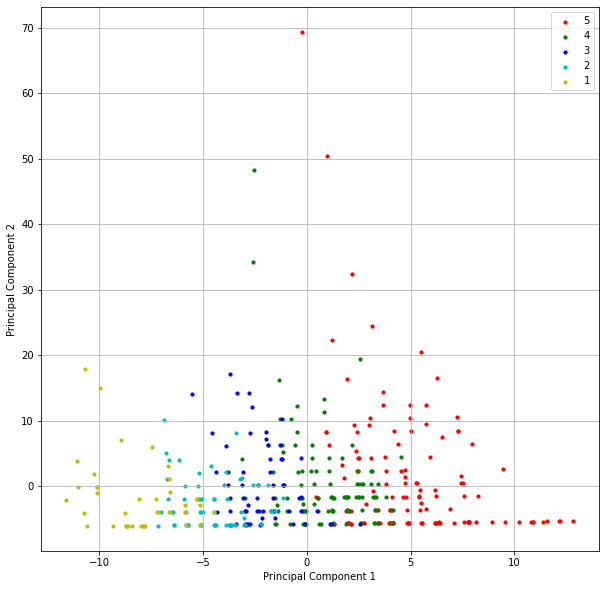

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_x = PCA(n_components=2).fit_transform(x)

targets = [5, 4, 3, 2, 1]
colors = ['r', 'g', 'b', 'c', 'y']

plt.figure(figsize = (10,10))

for target, color in zip(targets,colors):
  index = np.where(y==target)
  plt.scatter(pca_x[index,1], pca_x[index,0], s=10, label=target, c=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()